# Lettuce Classifier
a binary classifier on romaine and iceberg lettuce

This is an adaptation of the [fastai notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb)

# Introduction

The purpose of this notebook is to illustrate the machine learning workflow (as I know it 😄) using the techniques shared in the fast.ai deep learning course. 

This notebook is not meant to teach you how to do deep learning or how to use the fastai library. If you want to learn how to do those, then please do take the [course](https://course.fast.ai/)!

#### Table of Contents
1. [Stage 1 - Source and prepare your data](#stage1)
2. [Stage 2 - Code your model](#stage2)
3. [Stage 3 - Train, evaluate, and tune your model](#stage3)<br>
    &ensp;3.1 [Training](#training)<br>
    &ensp;3.2 [Interpretation, Evaluation](#interp)<br>
    &ensp;3.3 [Getting Predictions](#preds)<br>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# Import fastai library
from fastai import *
from fastai.vision import *

## Stage 1 - Source and prepare your data 
<a class='anchor' id='stage1'></a>

There are multiple ways to source your data. One way is to create your own dataset from Google Images. We're going to use a python script created by [Hardik Vasa](https://github.com/hardikvasa).

[More info on how to install and use the library here.](https://github.com/hardikvasa/google-images-download)

In [0]:
# Install the python library
!pip install google_images_download

     |████████████████████████████████| 911kB 4.1MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=de1c75762778b55d387fe1309ee44739cd25555841bfba28cbac499e02229a2a
  Stored in directory: /content/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [0]:
# Importing the library
from google_images_download import google_images_download

In [0]:
# Usage of google_images_download library
response = google_images_download.googleimagesdownload()   # class instantiation

arguments = {"keywords":"romaine lettuce,iceberg lettuce","limit":100}   # creating list of arguments (keywords : search keywords, 
                                                                         # limit : max no. of images to download)

paths = response.download(arguments)   # passing the arguments to the function


Item no.: 1 --> Item name = romaine lettuce
Evaluating...
Starting Download...
Completed Image ====> 1.E9KAjydhY9iv99p3VGhxkk-320-80.jpg
Completed Image ====> 2.romaine-lettuce.jpg
Completed Image ====> 3.romaine-lettuce.jpg
Completed Image ====> 4.californiafa.jpg
Completed Image ====> 5.istock-943351712.jpg
Completed Image ====> 6.105146304-GettyImages-504709870.jpg
Invalid or missing image format. Skipping...
Completed Image ====> 7.14494652_web1_lettuce-2468495_1920-copy.jpg
Completed Image ====> 8.Romaine.jpg
Completed Image ====> 9.RomaineLettuceNutritionHeader.jpg
Completed Image ====> 10.6ff44fc2-378f-4634-96b5-1854ee7f425e-large16x9_Romaine_Lettuce.jpg
Completed Image ====> 11.AR-304139755.jpg
Completed Image ====> 12.istock-911843202.jpg
Completed Image ====> 13.920x920.jpg
Completed Image ====> 14.81l3B5zz1NL._SY355_.jpg
Completed Image ====> 15.1513096479741.jpg
Completed Image ====> 16.Romaine%20Lettuce.jpg
Completed Image ====> 17.d475f905-b33a-4532-b50f-684f1408cd5f_1.d

In [0]:
# Checking directory, locate our data directory
# commands starting at "!" means it's a bash command (terminal)
!ls

00_notebook_tutorial.ipynb     lesson7_human_numbers.ipynb
crappify.py		       lesson7_resnet_mnist.ipynb
downloads		       lesson7_superres_gan.ipynb
export2.pkl		       lesson7_superres.ipynb
export3.pkl		       lettuce-classifier.ipynb
export.pkl		       main.pkl
imdb_replicate.ipynb	       MNIST.ipynb
lesson1_pets.ipynb	       movie_genre_2.ipynb
lesson2_download.ipynb	       movie_genre_3.ipynb
lesson3_camvid_tiramisu.ipynb  movie_genre.ipynb
lesson3_head_pose.ipynb        planet.ipynb
lesson3_planet.ipynb	       production2.pkl
lesson4_collab.ipynb	       production.pkl
lesson4_tabular.ipynb	       README.md
lesson5_sgd_mnist.ipynb        toxic_comments.ipynb
lesson6_pets_more.ipynb        Untitled.ipynb


In [0]:
# Setting file path of data to variable 'path'
# This serves as the directory of the data.
path = Path('downloads')
path.ls()

[PosixPath('downloads/iceberg lettuce'),
 PosixPath('downloads/romaine lettuce'),
 PosixPath('downloads/.ipynb_checkpoints')]

In [0]:
# Create a an array of classes (categorical variable to predict)
# This will be used for the loop below
classes = ['romaine lettuce','iceberg lettuce']

In [0]:
# verify_images() cleans our data of broken images.
# It also resizes the image to max_size to keep the data size small
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

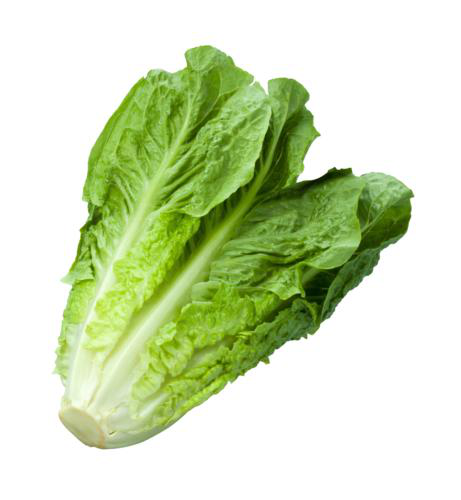

In [0]:
# Choose a random image from your data folder to display and examine
img = open_image(path/'romaine lettuce/8.Romaine.jpg') # Enter file path of image as parameter
img

In [0]:
# Data augmentation, it'll create more data by transforming the images (cropping, rotation, flipping, etc)
# It is said that creating more data by transforming them results to better performance

# Set transforms
tfms = get_transforms(flip_vert=True)

In [0]:
# Create our ImageDataBunch (fastai specific Class)
# Resize our images to size 228 (training data for computer vision models are of the same size)

data = (ImageList.from_folder(path) # Where is the data located? It's in the path
        
       .split_by_rand_pct(0.2)      # How do we split the data into training and validation set (a technique to measure model performance)
                                    # Randomly choosing 20% of data as validation set, leaving the remainging 80% as training set.
        
       .label_from_folder()         # How do we label our data (Which image is romaine or iceberg lettuce)? We label them by name.
        
       .transform(tfms, size=228)   # How is our data transformed? We defined it above using get_transforms
        
       .databunch())                # Converts our data into ImageDataBunch object

In [0]:
# Print classes
data.classes

['iceberg lettuce', 'romaine lettuce']

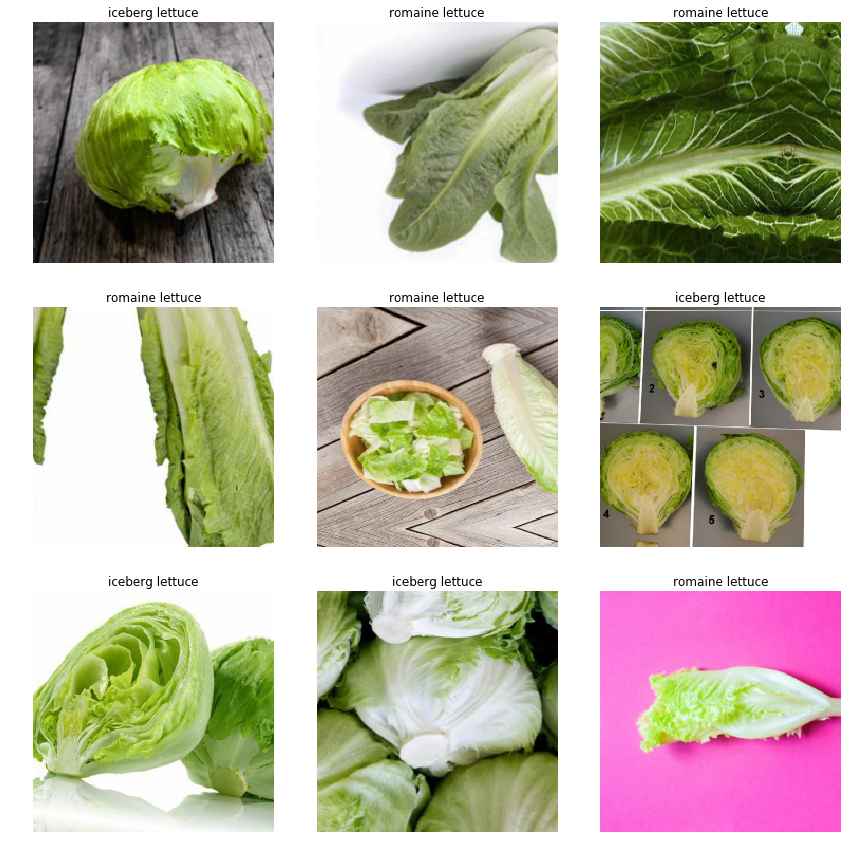

In [0]:
# Show images to get an idea of how our data looks like
data.show_batch(rows=3)

## Stage 2 - Code your model
<a id="stage2"></a>

fastai library made it easy to create a neural network and get a good performance by just using the defaults


In [0]:
# Instantiates a neural network
learn = create_cnn(data, models.resnet34, metrics=accuracy) # data : our images, 
                                                            # models.resnet34 : neural network architecture, 
                                                            # metrics : how model performance is measured

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
/usr/local/lib/python3.6/dist-packages/torch/hub.py:411: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 107853234.95it/s]


## Stage 3 - Train, evaluate, and tune your model
<a id="stage3"></a>

### Training

In [0]:
# a fastai function to find an optimal learning rate for our model
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-03
Min loss divided by 10: 1.20E-02


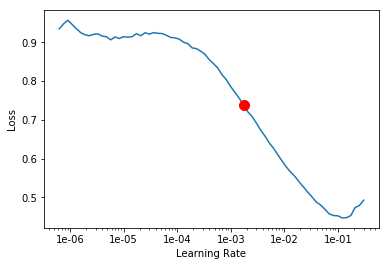

In [0]:
# Plot
# Choosse the learning rate with the steepest slope
learn.recorder.plot(suggestion=True) # suggestion=True shows the suggested learning rate

In [0]:
# Set learning rate
# In this case, we'll use the suggested learning rate
lr = 1.74E-03

In [0]:
# Train (fit) the model for 10 epochs
# One epoch means going through the entire trainind dataset once. 
# You can experiment on the number of epochs and learning rate to find the right balance.
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.920202,0.865088,0.513514,00:04
1,0.891081,0.632038,0.621622,00:03
2,0.809169,0.671340,0.567568,00:03
3,0.682640,0.656026,0.621622,00:03
4,0.590703,0.550017,0.756757,00:03
5,0.511080,0.462645,0.810811,00:03
6,0.452493,0.433231,0.837838,00:03
7,0.403050,0.408651,0.891892,00:03
8,0.363612,0.394775,0.891892,00:03
9,0.337418,0.379785,0.891892,00:03


In [0]:
# Save the trained weights of the model (to save time if you want to improve the model in the future)
learn.save('stage-1')

In [0]:
# Execute this code to load the weights without training again.
learn.load('stage-1')

### Interpretation, Evaluation
From here, you can understand your model better and make necessary tweaks to improve its performance

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

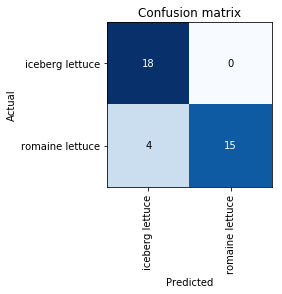

In [0]:
interp.plot_confusion_matrix()

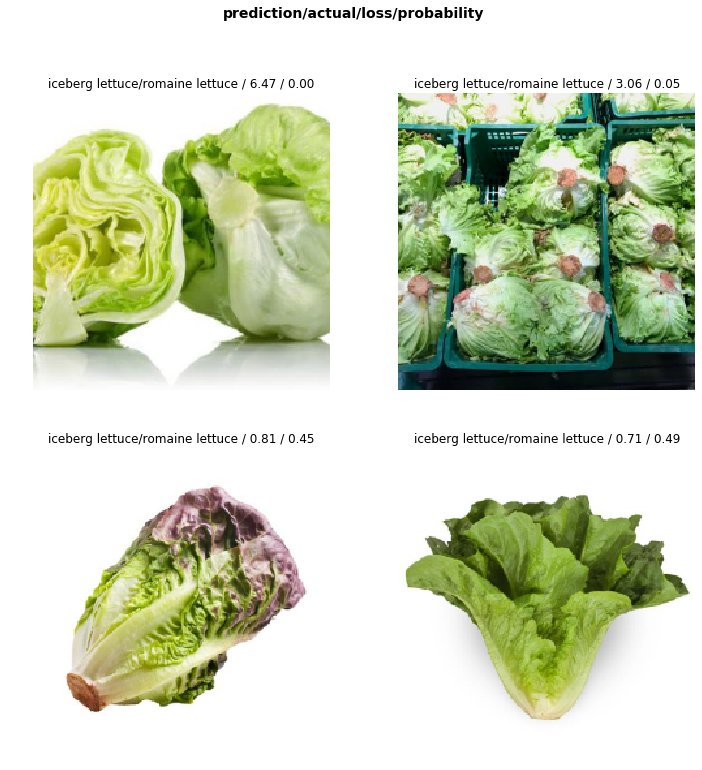

In [0]:
interp.plot_top_losses(4)

### Getting predictions

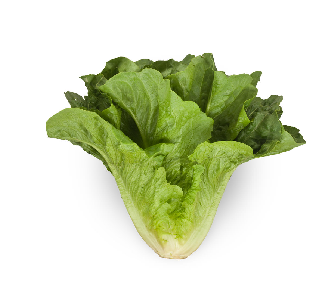

In [0]:
romaine_img = open_image(f"{path}/romaine_test.jpg")
romaine_img.show(figsize=(5,5))

In [0]:
prediction = learn.predict(romaine_img)[0]
prediction

Category romaine lettuce

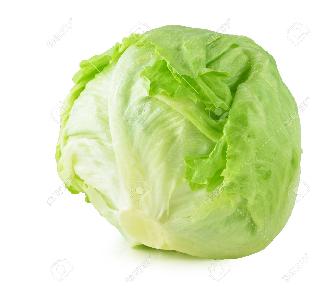

In [0]:
iceberg_img = open_image(f"{path}/iceberg_test.jpg")
iceberg_img.show(figsize=(5,5))

In [0]:
prediction = learn.predict(iceberg_img)[0]
prediction

Category iceberg lettuce

### Author's note:
#### I skipped the tuning part because my dataset is small and tuning it further will result to overfitting. These concepts may be arcane to you for now, but it'll all make sense when you start doing the course.